# Simulation study 
**proving, that cross-sectional normative models are good enough for longitudinal data analysis**

In [ ]:
#%run simulation_study_cycle.py
!python /home/barbora/Documents/Projects/Normative_Models/ESO/code/simulation_study_cycle.py 1

### **Original development**
- from here down

In [3]:
# Loading packages
import os, glob, pickle, time, sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pcntoolkit.util.utils import create_design_matrix

# custom functions
code_dir = ('/home/barbora/Documents/Projects/Normative_Models/ESO/code')
os.chdir(code_dir)
import clinics_desc_functions as custom

custom.set_seed(seed=42)

Random seed 42 has been set.


definition of paths to directories

In [4]:
project_dir = ('/home/barbora/Documents/Projects/Normative_Models')
simulations_dir = '/home/barbora/Documents/Projects/Normative_Models/ESO/simulations'
models_dir = '/home/barbora/Documents/Projects/Normative_Models/ESO/braincharts/models/lifespan_57K_82sites/'
models_pretrained_all = '/home/barbora/Documents/Projects/Normative_Models/ESO/braincharts/'
paper_im_dir = os.path.join(project_dir,'ESO', 'draft', 'img')

which IDP are we going to model?

In [3]:
import clinics_desc_functions as custom
# pretrained model
model_name, site_names, site_ids_tr, idp_ids = custom.pretrained_ini()

random_idp = idp_ids[15]#np.random.randint(len(idp_ids), size=1)

# one random model - just trying to get some reasonable coeffitients
model_path = os.path.join(models_dir,random_idp,'Models')

-------------------------------------------------------------------------------------------------------------------

All functions needed for the script
- generate controls data
- generate patients data
- function for plotting of longitudinal data

In [6]:
# Functions neede for the simulation study (will be later transfered to custom --- after debugging)
# Function to generate Subjects
def generate_longitudinal_subjects_template(model_path, random_idp, simulations_dir, no_females = 1000):
    """
    generates template and covariance matrix for longitudinal subjects
    template1, template2 = generate_longitudinal_subjects_template(model_path, random_idp, simulations_dir, no_females = 1000)
    
    model_path... path of model with coeffitients
    random_idp... name of random idp
    simulations_dir... path to simulations directory
    no_females... number of females in the population (default = 1000), same nuber will be used for males
    """
    # seed the random number generator
    np.random.seed(42)

    # Create template dataset for V1 and V2
    v1_age = np.random.randint(18,60,size=no_females*2)
    v2_age = v1_age+1

    sex = np.concatenate([np.zeros([no_females]),np.ones([no_females])])
    id = ['c'+str(i) for i in range(1,no_females*2+1)]

    v1_template = pd.DataFrame(np.array([v1_age,sex]).T, columns=['age', 'sex'], index=id)
    v2_template = pd.DataFrame(np.array([v2_age,sex]).T, columns=['age', 'sex'], index=id)

    v1_template['site'] = 'simulation'
    v1_template['sitenum'] = 4223
    v2_template['site'] = 'simulation'
    v2_template['sitenum'] = 4223

    # Deterministic part of the simulation
    # phi(x)*w --> Yhat
    cols_cov = ['age','sex']
    v1_covars = create_design_matrix(v1_template[cols_cov], 
                                site_ids = v1_template['site'],
                                all_sites = site_ids_tr,
                                basis = 'bspline', 
                                xmin = -5, 
                                xmax = 110)

    v2_covars = create_design_matrix(v2_template[cols_cov], 
                                site_ids = v2_template['site'],
                                all_sites = site_ids_tr,
                                basis = 'bspline', 
                                xmin = -5, 
                                xmax = 110)

    os.makedirs(os.path.join(simulations_dir,'V1',random_idp), exist_ok=True)
    os.makedirs(os.path.join(simulations_dir,'V2',random_idp), exist_ok=True)
    v1_fsaveto = os.path.join(simulations_dir,'V1',random_idp,'v1_controls.txt')
    np.savetxt(v1_fsaveto, v1_covars)
    v2_fsaveto = os.path.join(simulations_dir,'V2',random_idp,'v2_controls.txt')
    np.savetxt(v2_fsaveto, v2_covars)

    from temp_func_pcn import predict
    v1_template['Yhat'], v1_s2_orig = predict(v1_fsaveto, respfile = None, alg='blr', model_path=model_path)
    v2_template['Yhat'], v2_s2_orig = predict(v2_fsaveto, respfile = None, alg='blr', model_path=model_path)
    
    return v1_template, v2_template


def add_noise_to_subjects(v1_template, v2_template, model_path, random_idp, var_population = 1, var_noise = 0.5, effect='none', effect_size = 0, effect_var = 0, seed = 42):
    """
    Function will generate brain data based on coeffitiens from chosen model
    v1_template, v2_template = add_noise_to_subjects(template1, template2, model_path, random_idp, var_population = 1, var_noise = 0.5, effect='none', effect_size = 0, effect_var = 0, seed = 42)
    
    template1, template2... templates generated by generate_longitudinal_subjects_template
    model_path... path of model with coeffitients
    var_population... variation in population (default = 1)
    var_noise... variation in noise (default = 0.5)
    effect...   - none (use to generate controls)
                - uniform
                - normal
    effect_size... effect size (default = 0)
    effect_var... effect variation (default = 0)
    seed... seed for random number generator (default = 42)
    """
    from pcntoolkit.normative import estimate, predict, evaluate

    # Adding the position within the population to every individual
    np.random.seed(seed)

    if var_population == 'model':
        with open(os.path.join(model_path, 'NM_0_0_estimate.pkl'), 'rb') as handle:\
            nm = pickle.load(handle) 
        beta, junk1, junk2 = nm.blr._parse_hyps(nm.blr.hyp, v1_covars)        
        v1_template['pop'] = np.random.normal(0, 1/beta, size=v1_template.shape[0])
        beta = 1/beta
    else:
        v1_template['pop'] = np.random.normal(0,var_population,size=v1_template.shape[0])
        beta = var_population + var_noise

    # Adding the effect if there is any (controls vs patients)
    if effect == 'none':
        effect_size = 0
    elif effect == 'normal':
        effect_size = np.random.normal(effect_size, effect_var, size=no_patients)
    elif effect == 'uniform':
        effect_size = effect_size

    v1_template['effect_size'] = effect_size
    v1_template['Yhat_pop'] = v1_template['Yhat'] + v1_template['pop'] + v1_template['effect_size']
    v1_template['noise'] = np.random.normal(0,var_noise,size=v1_template.shape[0])
    v1_template['warped'] = v1_template['Yhat'] + v1_template['pop'] + v1_template['effect_size'] + v1_template['noise']

    v2_template['pop'] = v1_template['pop']
    v2_template['effect_size'] = effect_size
    v2_template['Yhat_pop'] = v2_template['Yhat'] + v2_template['pop'] + v2_template['effect_size']
    v2_template['noise'] = np.random.normal(0,var_noise,size=v2_template.shape[0])
    v2_template['warped'] = v2_template['Yhat'] + v2_template['pop'] + v2_template['effect_size'] + v2_template['noise']


    # Now warping into the original space
    # load the normative model
    with open(os.path.join(model_path, 'NM_0_0_estimate.pkl'), 'rb') as handle:
        nm = pickle.load(handle) 

    # get the warp and warp parameters
    W = nm.blr.warp
    warp_param = nm.blr.hyp[1:nm.blr.warp.get_n_params()+1] 
        
    # first, we warp predictions for the true data and compute evaluation metrics
    v1_template[random_idp] = W.warp_predictions(np.squeeze(v1_template['warped'].to_numpy()), np.squeeze(beta), warp_param)[0]
    v2_template[random_idp] = W.warp_predictions(np.squeeze(v2_template['warped'].to_numpy()), np.squeeze(beta), warp_param)[0]

    return(v1_template, v2_template, beta)


###
# Train_test_split - split across sites, keep 30% as TESTING
###
def run_and_attach(v1_cont, v2_cont, v1_pat, v2_pat, simulations_dir, random_idp):

    from temp_func import pretrained_adapt_controls

    from sklearn.model_selection import StratifiedShuffleSplit
    sss = StratifiedShuffleSplit(n_splits=2, test_size=0.25, random_state=42)
    
    for train, test in sss.split(v1_cont.index,  v1_cont['sex']):

        #iter_dir = isim_dir
        #os.makedirs(iter_dir, exist_ok=True)
        site_ids_te =  sorted(set(v1_pat['site'].to_list()))

        for ivisit in range(1,3):
            if ivisit == 1:
                df_te = v1_pat
                df_tec = v1_cont.iloc[test]
                df_ad = v1_cont.iloc[train]

            elif ivisit == 2:
                df_te = v2_pat
                df_tec = v2_cont.iloc[test]
                df_ad = v1_cont.iloc[train]

            visit_dir = os.path.join(simulations_dir, 'V'+str(ivisit), random_idp)
            os.makedirs(visit_dir, exist_ok=True)
            

            #custom.pretrained_adapt_small(random_idp, site_ids_tr, site_ids_te, model_path, visit_dir, df_ad, df_te)
            pretrained_adapt_controls([random_idp], site_ids_tr, site_ids_te, models_dir, os.path.join(simulations_dir, 'V'+str(ivisit)), df_ad, df_tec, df_te)

            # create textfiles for checking
            df_te.to_csv(os.path.join(visit_dir, 'patients.csv'), sep=' ', index=True)
            df_tec.to_csv(os.path.join(visit_dir, 'controls_test.csv'), sep=' ', index=True)
            df_ad.to_csv(os.path.join(visit_dir, 'controls_adapt.csv'), sep=' ', index=True)

    # Attach
    # Load testing controls and poatients (original dataframes) and attach the z-scores
    v1_cont = pd.read_table(os.path.join(simulations_dir, 'V1', random_idp, 'controls_test.csv'), sep=' ', index_col=0)
    v2_cont = pd.read_table(os.path.join(simulations_dir, 'V2', random_idp, 'controls_test.csv'), sep=' ', index_col=0)

    v1_pat = pd.read_table(os.path.join(simulations_dir, 'V1', random_idp, 'patients.csv'), sep=' ', index_col=0)
    v2_pat = pd.read_table(os.path.join(simulations_dir, 'V2', random_idp, 'patients.csv'), sep=' ', index_col=0)

    v1_cont_z = pd.read_table(os.path.join(simulations_dir, 'V1', random_idp, 'Z_conttest.txt'), sep=' ', header=None)
    v2_cont_z = pd.read_table(os.path.join(simulations_dir, 'V2', random_idp, 'Z_conttest.txt'), sep=' ', header=None)

    v1_pat_z = pd.read_table(os.path.join(simulations_dir, 'V1', random_idp, 'Z_predict.txt'), sep=' ', header=None)
    v2_pat_z = pd.read_table(os.path.join(simulations_dir, 'V2', random_idp, 'Z_predict.txt'), sep=' ', header=None)

    v1_cont_yhat = pd.read_table(os.path.join(simulations_dir, 'V1', random_idp, 'yhat_conttest.txt'), sep=' ', header=None)
    v2_cont_yhat = pd.read_table(os.path.join(simulations_dir, 'V2', random_idp, 'yhat_conttest.txt'), sep=' ', header=None)

    v1_pat_yhat = pd.read_table(os.path.join(simulations_dir, 'V1', random_idp, 'yhat_predict.txt'), sep=' ', header=None)
    v2_pat_yhat = pd.read_table(os.path.join(simulations_dir, 'V2', random_idp, 'yhat_predict.txt'), sep=' ', header=None)

    v1_cont_y = pd.read_table(os.path.join(simulations_dir, 'V1', random_idp, 'y_conttest.txt'), sep=' ', header=None)
    v2_cont_y = pd.read_table(os.path.join(simulations_dir, 'V2', random_idp, 'y_conttest.txt'), sep=' ', header=None)

    v1_pat_y = pd.read_table(os.path.join(simulations_dir, 'V1', random_idp, 'y_predict.txt'), sep=' ', header=None)
    v2_pat_y = pd.read_table(os.path.join(simulations_dir, 'V2', random_idp, 'y_predict.txt'), sep=' ', header=None)

    # Attach the z-scores to the original dataframes
    v1_cont[random_idp+'_z_orig'] = v1_cont_z[0].to_numpy()
    v1_cont[random_idp+'_yhat'] = v1_cont_yhat[0].to_numpy()
    v1_cont[random_idp+'_y'] = v1_cont_y[0].to_numpy()

    v2_cont[random_idp+'_z_orig'] = v2_cont_z[0].to_numpy()
    v2_cont[random_idp+'_yhat'] = v2_cont_yhat[0].to_numpy()
    v2_cont[random_idp+'_y'] = v2_cont_y[0].to_numpy()

    v1_pat[random_idp+'_z_orig'] = v1_pat_z[0].to_numpy()
    v1_pat[random_idp+'_yhat'] = v1_pat_yhat[0].to_numpy()
    v1_pat[random_idp+'_y'] = v1_pat_y[0].to_numpy()

    v2_pat[random_idp+'_z_orig'] = v2_pat_z[0].to_numpy()
    v2_pat[random_idp+'_yhat'] = v2_pat_yhat[0].to_numpy()
    v2_pat[random_idp+'_y'] = v2_pat_y[0].to_numpy()

    return v1_cont, v2_cont, v1_pat, v2_pat

def var_test(x, va0, direction = "two-tailed", alpha = 0.05):
    """
    var_test(x, va0, direction = "two-tailed", alpha = 0.05)

    x... vector of data
    va0... variance to test against
    direction... "lower", "upper", "two-tailed" (default)
    alpha... significance level (default 0.05)
    """

    import numpy as np
    from scipy.stats import chi2

    n = len(x)
    Q = (n - 1) * np.var(x) / va0 

    pval = 1-chi2.cdf(Q, n)

    if direction == "lower":
        q = chi2.ppf(alpha, n - 1)
        
        if Q <= q:
            return pval, "H_0 rejected"
        else:
            return pval, "H_0 not rejected"

    elif direction == "upper":
        q = chi2.ppf(1 - alpha, n - 1)
        
        if Q >= q:
            return pval, "H_0 rejected"
        else:
            return pval, "H_0 not rejected"
    else:
        q1 = chi2.ppf(alpha / 2, n - 1)
        q2 = chi2.ppf(1 - (alpha / 2), n - 1)
        if Q <= q1 or Q >= q2:
            return pval, "H_0 rejected"
        else:
            return pval, "H_0 not rejected"



# LONGITUDINAL PLOTTING FUNCTION
# check the controls are not dramatically different between the two visits
# x coordinates - age - two rows of data
def plot_longitudinal(v1_age, v2_age,  v1_Yhat, v2_Yhat, to_plot = True, v1_col='lightblue', v2_col='lightcoral', tick_col = 'gray', title = '', xlabel = 'Age', ylabel = 'Yhat'):
    """
    The function will plot the longitudinal data as connected dots
    plot_longitudinal(v1_age, v2_age,  v1_Yhat, v2_Yhat, to_plot = True, v1_col='lightblue', v2_col='lightcoral', tick_col = 'gray', title = '', xlabel = 'Age', ylabel = 'Yhat')
    
    v1_age, v2_age... what will be plotted on x axis, ideally 1xn 2D array
    v1_Yhat, v2_Yhat... what will be plotted on y axis, ideally 1xn 2D array
    to_plot... if True, the plot will be shown, if False, the plot will be returned
    v1_col, v2_col, tick_col... color of the dots for the first and second visit
    title, xlabel, ylabel... title and labels of the plot
    """
    def check_dimensions(vector):
        """
        check_dimensions(vector)
        reshapes array into 2D 1xn array
        """
        if len(vector.shape) == 1:
            return vector[np.newaxis,:]
        elif len(vector.shape) == 2:
            if vector.shape[0] > vector.shape[1]:
                return vector.T
            else:
                return vector
        else:
            return False

    v1_age = check_dimensions(v1_age)
    v2_age = check_dimensions(v2_age)
    v1_Yhat = check_dimensions(v1_Yhat)
    v2_Yhat = check_dimensions(v2_Yhat)
    
    x_coords = np.concatenate([v1_age, v2_age],axis=0)
    y_coords = np.concatenate([v1_Yhat, v2_Yhat],axis=0)

    if to_plot:
        fig, ax = plt.subplots()
        plt.plot(x_coords, y_coords, color=tick_col)
        plt.scatter(v1_age, v1_Yhat, color=v1_col, s=20, alpha = 0.5)
        plt.scatter(v2_age, v2_Yhat, color=v2_col, s=20, alpha = 0.5)

    return ax


In [ ]:
# Run the simulation
# custom functions
code_dir = ('/home/barbora/Documents/Projects/Normative_Models/ESO/code')
os.chdir(code_dir)
import clinics_desc_functions as custom

custom.set_seed(seed=42)

# pretrained model
model_name, site_names, site_ids_tr, idp_ids = custom.pretrained_ini(sites=82)
thick_idp = [i for i in idp_ids if 'thick' in i]

# Takes the IDP to process as an input
import sys
random_idp_id = sys.argv[1]
print(random_idp_id)
random_idp=thick_idp[int(random_idp_id)] # prints var1


# create empty data array (3D) to store the results in
data = np.zeros([len(np.arange(1, 5.5, 0.5)) * len(np.arange(0.5, 3.5, 0.5)), 10])

###
# cycle is cancelled, this is going to be paralelized for effeciency
###
print(random_idp)

# one random model - just trying to get some reasonable coeffitients
model_path = os.path.join(models_dir,random_idp,'Models')

# to define row in the data
irow = 0
for ivar_population in np.arange(1, 5.5, 0.5):
    print(str(ivar_population))
    for ivar_noise in np.arange(0.5, 3.5, 0.5):

        # generate the template for the analysis
        v1_cont, v2_cont = generate_longitudinal_subjects_template(model_path, random_idp, simulations_dir, no_females = 1000)
        v1_pat, v2_pat = generate_longitudinal_subjects_template(model_path, random_idp, simulations_dir, no_females = 100)

        ###
        # Generate controls and patients
        ###
        v1_cont, v2_cont, s2_model = add_noise_to_subjects(v1_cont, v2_cont, model_path, random_idp, var_population = 1, var_noise = 0.5, effect='none', effect_size = 0, effect_var = 0, seed = irow)
        v1_pat, v2_pat, s2_model = add_noise_to_subjects(v1_pat, v2_pat, model_path, random_idp, var_population = 1, var_noise = 0.5, effect='none', effect_size = 0, effect_var = 0, seed = irow)
        
        ###
        # potential effect - not now, only checking controls
        #v2_pat[random_idp] = v2_pat[random_idp] - 0.2

        ###
        # Run and attach the results of normative model
        v1_cont, v2_cont, v1_pat, v2_pat = run_and_attach(v1_cont, v2_cont, v1_pat, v2_pat, simulations_dir, random_idp)

        ###
        # Statistics
        nom = ((v2_cont[random_idp+'_y'] - v2_cont[random_idp+'_yhat']) - (v1_cont[random_idp+'_y'] - v1_cont[random_idp+'_yhat']))
        cont_var = ((v2_cont[random_idp+'_y'] - v2_cont[random_idp+'_yhat']) - (v1_cont[random_idp+'_y'] - v1_cont[random_idp+'_yhat'])).var()
        cont_z = nom/np.sqrt(cont_var)

        nom = ((v2_pat[random_idp+'_y'] - v2_pat[random_idp+'_yhat']) - (v1_pat[random_idp+'_y'] - v1_pat[random_idp+'_yhat']))
        pat_z = nom/np.sqrt(cont_var)

        # print into the dataframe
        data[irow, 0] = ivar_population
        data[irow, 1] = ivar_noise
        data[irow, 2] = cont_z.mean()
        data[irow, 3] = ttest_1samp(cont_z, 0)[1]
        data[irow, 4] = cont_z.var()
        data[irow, 5] = var_test(cont_z.to_numpy(), 1)[0]
        data[irow, 6] = pat_z.mean()
        data[irow, 7] = ttest_1samp(pat_z, 0)[1]
        data[irow, 8] = pat_z.var()
        data[irow, 9] = var_test(pat_z.to_numpy(), 1)[0]

        irow += 1
        del v1_cont, v2_cont, v1_pat, v2_pat
        
        files  =glob.glob(os.path.join(simulations_dir, 'V1', random_idp, '*'))
        [os.remove(f) for f in files]
        files  =glob.glob(os.path.join(simulations_dir, 'V2', random_idp, '*'))
        [os.remove(f) for f in files]
        


data = pd.DataFrame(data, columns = ['var_pop', 'var_noise', 'cont_z_mean', 'cont_z_mean_p', 'cont_z_var', 'cont_z_var_p', 'pat_z_mean', 'pat_z_mean_p', 'pat_z_var', 'pat_z_var_p'])
data.to_csv(os.path.join(simulations_dir, 'simulations_'+random_idp+'.csv'), sep=' ')


### Comparison of model performance with the orignal data
- so now the tricky part comes
- first, just compare the z-scores, which, ideally, should reflect the **pop** parameter across visits and subjects

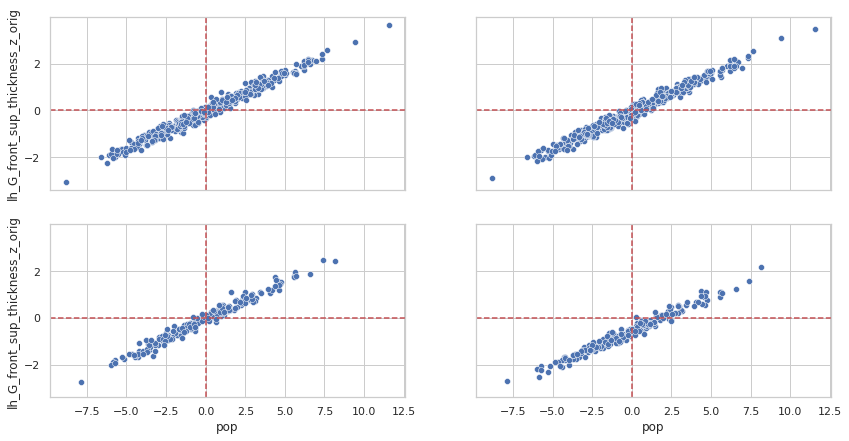

In [15]:
# Plot the z-scores
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(2,2, figsize=(14,7), sharex=True, sharey=True)
sns.scatterplot(data=v1_cont, x='pop', y=random_idp+'_z_orig', ax=ax[0,0])
sns.scatterplot(data=v2_cont, x='pop', y=random_idp+'_z_orig', ax=ax[0,1])
sns.scatterplot(data=v1_pat, x='pop', y=random_idp+'_z_orig', ax=ax[1,0])
sns.scatterplot(data=v2_pat, x='pop', y=random_idp+'_z_orig', ax=ax[1,1])
for i in range(2):
    for j in range(2):
        ax[i,j].axhline(y=0, color='r', linestyle='--')
        ax[i,j].axvline(x=0, color='r', linestyle='--')


### **Compute longitudinal statistics**

In [38]:
nom = ((v2_cont[random_idp+'_y'] - v2_cont[random_idp+'_yhat']) - (v1_cont[random_idp+'_y'] - v1_cont[random_idp+'_yhat']))
cont_var = ((v2_cont[random_idp+'_y'] - v2_cont[random_idp+'_yhat']) - (v1_cont[random_idp+'_y'] - v1_cont[random_idp+'_yhat'])).var()
cont_z = nom/np.sqrt(cont_var)

nom = ((v2_cont_cont_y - v2_cont_cont_yhat) - (v1_cont_cont_y - v1_cont_cont_yhat))
cont_cont_z = nom/np.sqrt(cont_var)

#nom = ((v2_pat[random_idp+'_y'] - v2_pat[random_idp+'_yhat']) - (v1_pat[random_idp+'_y'] - v1_pat[random_idp+'_yhat']))
#pat_z = nom/np.sqrt(cont_var)
